# 4. Word Window Classification and Neural Networks 

I recommend you take a look at these material first.
* https://en.wikipedia.org/wiki/Named-entity_recognition

You also need <a href="http://sklearn-crfsuite.readthedocs.io/en/latest/index.html">sklearn_crfsuite</a> latest version for print confusion matrix

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import nltk
import random
import numpy as np
from collections import Counter
flatten = lambda l: [item for sublist in l for item in sublist]
from sklearn_crfsuite import metrics
random.seed(1024)

print(torch.__version__)
print(nltk.__version__)

USE_CUDA = torch.cuda.is_available()
gpus = [0]
# torch.cuda.set_device(gpus[0])

FloatTensor = torch.cuda.FloatTensor if USE_CUDA else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if USE_CUDA else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if USE_CUDA else torch.ByteTensor

In [4]:
def getBatch(batch_size, train_data):
    random.shuffle(train_data)
    sindex = 0
    eindex = batch_size
    while eindex < len(train_data):
        batch = train_data[sindex: eindex]
        temp = eindex
        eindex = eindex + batch_size
        sindex = temp
        yield batch
    
    if eindex >= len(train_data):
        batch = train_data[sindex:]
        yield batch

In [5]:
def prepare_sequence(seq, word2index):
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return Variable(LongTensor(idxs))

def prepare_word(word, word2index):
    return Variable(LongTensor([word2index[word]]) if word2index.get(word) is not None else LongTensor([word2index["<UNK>"]]))

def prepare_tag(tag,tag2index):
    return Variable(LongTensor([tag2index[tag]]))

## Data load and Preprocessing 

CoNLL-2002 Shared Task: Language-Independent Named Entity Recognition <br>
https://www.clips.uantwerpen.be/conll2002/ner/

In [6]:
corpus = nltk.corpus.conll2002.iob_sents()

In [7]:
data = []
for cor in corpus:
    sent, _, tag = list(zip(*cor))
    data.append([sent, tag])

In [8]:
print(len(data))
print(data[0])

35651
[('Sao', 'Paulo', '(', 'Brasil', ')', ',', '23', 'may', '(', 'EFECOM', ')', '.'), ('B-LOC', 'I-LOC', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'O')]


### Build Vocab

In [9]:
sents,tags = list(zip(*data))
vocab = list(set(flatten(sents)))
tagset = list(set(flatten(tags)))

In [10]:
word2index={'<UNK>' : 0, '<DUMMY>' : 1} # dummy token is for start or end of sentence
for vo in vocab:
    if word2index.get(vo) is None:
        word2index[vo] = len(word2index)
index2word = {v:k for k, v in word2index.items()}

tag2index = {}
for tag in tagset:
    if tag2index.get(tag) is None:
        tag2index[tag] = len(tag2index)
index2tag={v:k for k, v in tag2index.items()}

### Prepare data
Example : Classify 'Paris' in the context of this sentence with window length 2

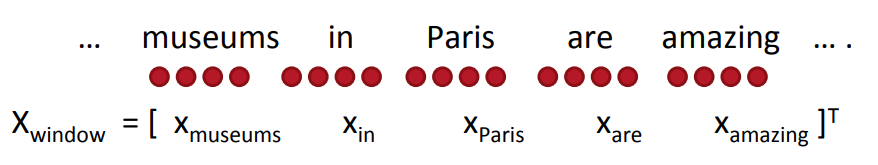

In [11]:
# borrowed image from http://web.stanford.edu/class/cs224n/lectures/cs224n-2017-lecture4.pdf
from IPython.display import Image
Image(filename='../images/04.window-data.png')

In [12]:
WINDOW_SIZE = 2
windows = []

In [13]:
for sample in data:
    dummy = ['<DUMMY>'] * WINDOW_SIZE
    window = list(nltk.ngrams(dummy + list(sample[0]) + dummy, WINDOW_SIZE * 2 + 1))
    windows.extend([[list(window[i]), sample[1][i]] for i in range(len(sample[0]))])

In [14]:
windows[0]

[['<DUMMY>', '<DUMMY>', 'Sao', 'Paulo', '('], 'B-LOC']

In [15]:
len(windows)

678377

In [16]:
random.shuffle(windows)

train_data = windows[:int(len(windows) * 0.9)]
test_data = windows[int(len(windows) * 0.9):]

## Modeling 

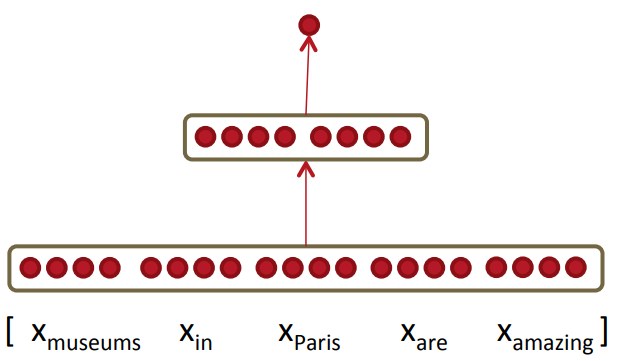

In [17]:
# borrowed image from http://web.stanford.edu/class/cs224n/lectures/cs224n-2017-lecture4.pdf
from IPython.display import Image
Image(filename='../images/04.window-classifier-architecture.png')

In [18]:
class WindowClassifier(nn.Module): 
    def __init__(self, vocab_size, embedding_size, window_size, hidden_size, output_size):

        super(WindowClassifier, self).__init__()
        
        self.embed = nn.Embedding(vocab_size, embedding_size)
        self.h_layer1 = nn.Linear(embedding_size * (window_size * 2 + 1), hidden_size)
        self.h_layer2 = nn.Linear(hidden_size, hidden_size)
        self.o_layer = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim=1)
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, inputs, is_training=False): 
        embeds = self.embed(inputs) # BxWxD
        # 把W*D打平，把window内部的W个单词打平拼起来
        concated = embeds.view(-1, embeds.size(1)*embeds.size(2)) # Bx(W*D)
        h0 = self.relu(self.h_layer1(concated))
        if is_training:
            h0 = self.dropout(h0)
        h1 = self.relu(self.h_layer2(h0))
        if is_training:
            h1 = self.dropout(h1)
        out = self.softmax(self.o_layer(h1))
        return out

In [19]:
BATCH_SIZE = 128
EMBEDDING_SIZE = 50 # x (WINDOW_SIZE*2+1) = 250
HIDDEN_SIZE = 300
EPOCH = 3
LEARNING_RATE = 0.001

## Training 

It takes for a while if you use just cpu.

In [20]:
model = WindowClassifier(len(word2index), EMBEDDING_SIZE, WINDOW_SIZE, HIDDEN_SIZE, len(tag2index))
if USE_CUDA:
    model = model.cuda()
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [21]:
for epoch in range(EPOCH):
    losses = []
    for i,batch in enumerate(getBatch(BATCH_SIZE, train_data)):
        x,y=list(zip(*batch))
        inputs = torch.cat([prepare_sequence(sent, word2index).view(1, -1) for sent in x])
        targets = torch.cat([prepare_tag(tag, tag2index) for tag in y])
        model.zero_grad()
        preds = model(inputs, is_training=True)
        loss = loss_function(preds, targets)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()

        if i % 1000 == 0:
            print("[%d/%d] mean_loss : %0.2f" %(epoch, EPOCH, np.mean(losses)))
            losses = []

[0/3] mean_loss : 2.41
[0/3] mean_loss : 0.47
[0/3] mean_loss : 0.37
[0/3] mean_loss : 0.31
[0/3] mean_loss : 0.28
[1/3] mean_loss : 0.16
[1/3] mean_loss : 0.22
[1/3] mean_loss : 0.21
[1/3] mean_loss : 0.20
[1/3] mean_loss : 0.19
[2/3] mean_loss : 0.10
[2/3] mean_loss : 0.15
[2/3] mean_loss : 0.14
[2/3] mean_loss : 0.15
[2/3] mean_loss : 0.14


## Test 

In [22]:
for_f1_score = []

In [23]:
accuracy = 0
for test in test_data:
    x, y = test[0], test[1]
    input_ = prepare_sequence(x, word2index).view(1, -1)

    i = model(input_).max(1)[1]
    pred = index2tag[i.data.tolist()[0]]
    for_f1_score.append([pred, y])
    if pred == y:
        accuracy += 1

print(accuracy/len(test_data) * 100)

95.80765942392169


This high score is because most of labels are 'O' tag. So we need to measure f1 score.

### Print Confusion matrix 

In [24]:
y_pred, y_test = list(zip(*for_f1_score))

In [25]:
sorted_labels = sorted(
    list(set(y_test) - {'O'}),
    key=lambda name: (name[1:], name[0])
)

In [26]:
sorted_labels

['B-LOC', 'I-LOC', 'B-MISC', 'I-MISC', 'B-ORG', 'I-ORG', 'B-PER', 'I-PER']

In [27]:
y_pred = [[y] for y in y_pred] # this is because sklearn_crfsuite.metrics function flatten inputs
y_test = [[y] for y in y_test]

In [28]:
print(metrics.flat_classification_report(y_test, y_pred, labels = sorted_labels, digits=3))

              precision    recall  f1-score   support

       B-LOC      0.739     0.728     0.733      1136
       I-LOC      0.568     0.519     0.542       320
      B-MISC      0.732     0.469     0.572       801
      I-MISC      0.619     0.337     0.437       646
       B-ORG      0.772     0.698     0.733      1343
       I-ORG      0.751     0.713     0.732       917
       B-PER      0.813     0.760     0.786      1304
       I-PER      0.873     0.835     0.853       961

   micro avg      0.765     0.669     0.714      7428
   macro avg      0.733     0.632     0.674      7428
weighted avg      0.758     0.669     0.706      7428



### TODO

* use max-margin objective function http://pytorch.org/docs/master/nn.html#multilabelmarginloss